In [52]:
from config import Config
from series_processing import process_series, bin_data
from file_io import (
    check_and_load_or_process)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

Text(0.5, 1.0, 'Transfer Funtion')

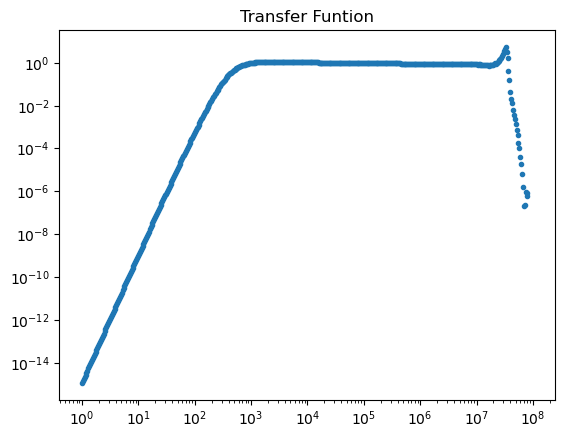

In [53]:
def transfer(freq, response):
    df = pd.read_csv(r"C:\Users\mcthu\Downloads\2 micron data\no_filter_response.txt")
    freqs = np.array(df[df.keys()[0]])
    r = np.array(df[df.keys()[1]])
    interpolation = scipy.interpolate.interp1d(freqs, r, fill_value = "extrapolate")

    def low_freq_fit(x):
        A, B =   -306.24611144, 184968.79274103
        C = 1 / (2*np.pi*10**-6*1000)
        Sallen_key = x**2 / (x**2 + A*x + B)
        RC_high_pass = x / (x +C )
        return (Sallen_key*RC_high_pass)**2

    return np.where(freq < 10**5, response / low_freq_fit(freq), response / interpolation(freq))

# Check out the tranfer function

freq = np.logspace(0, 8, 500)  # Frequencies from 10 Hz to 1 MHz
flat_psd = np.ones_like(freq)  # Flat PSD
psd_combined_f = transfer(freq, flat_psd)

plt.plot(freq, 1/psd_combined_f, ".")
plt.xscale("log")
plt.yscale("log")
plt.title("Transfer Funtion")

In [ ]:
HP_filename = r"C:\Users\mcthu\Downloads\2 micron data\Friday_data_set"
hp_offset = 73671700
num_files = 10
traces_per_file = 3
traces_HP = check_and_load_or_process("", hp_offset, HP_filename, "X", num_files, traces_per_file)

time_hp = np.arange(0, len(traces_HP[0]['series']))
conf_hp = Config(**traces_HP[0]['args'])
conf_hp.print()
time_hp = time_hp * (1/conf_hp.sampling_rate)

plt.figure(figsize=(10, 6))
for trace in traces_HP:
    plt.plot(time_hp, trace['series'], linewidth = .05)

plt.title("High Power Traces")
plt.show()


Processing data for 
Reading  C:\Users\mcthu\Downloads\2 micron data\Friday_data_set 0
data_col  X
Reading  C:\Users\mcthu\Downloads\2 micron data\Friday_data_set 1
data_col  X
Reading  C:\Users\mcthu\Downloads\2 micron data\Friday_data_set 2
data_col  X
Reading  C:\Users\mcthu\Downloads\2 micron data\Friday_data_set 3
data_col  X
Reading  C:\Users\mcthu\Downloads\2 micron data\Friday_data_set 4
data_col  X
Reading  C:\Users\mcthu\Downloads\2 micron data\Friday_data_set 5
data_col  X
Reading  C:\Users\mcthu\Downloads\2 micron data\Friday_data_set 6
data_col  X
Reading  C:\Users\mcthu\Downloads\2 micron data\Friday_data_set 7
data_col  X
Reading  C:\Users\mcthu\Downloads\2 micron data\Friday_data_set 8
data_col  X
Reading  C:\Users\mcthu\Downloads\2 micron data\Friday_data_set 9
data_col  X
MASS TOTAL IS 1.1309733552923254e-14
d: 2e-06
a: 1e-06
eta: 0.001
rho_silica: 2200
rho_f: 1000
sampling_rate: 200000000.0
track_len: 2097152
stop: None
start: None
mass: 9.215338450530058e-15
mass_to

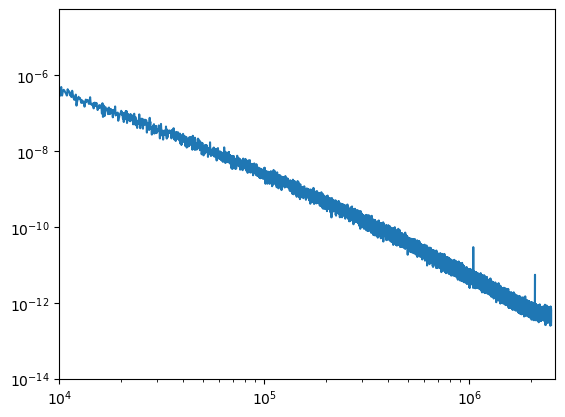

In [46]:
#bin data
bin = 40
all_hp_series = []

for trace in traces_HP:
    series = bin_data(trace['series'], bin)
    all_hp_series.append(series)

all_hp_psd = []
frequency = 0

for series in all_hp_series:
    frequency, psd = scipy.signal.periodogram(series, fs=conf_hp.sampling_rate/bin, scaling="density")
    all_hp_psd.append(psd)

hp_avg_psd = np.mean(all_hp_psd, axis=0)

plt.plot(frequency, hp_avg_psd)
plt.ylim(bottom=1e-14)
plt.xlim(left=1e4)
plt.xscale('log')
plt.yscale('log')

In [47]:
# def remove_frequency_artifact(freq, psd, artifact_center, artifact_bandwidth):
#
#     # Create a mask for frequencies to keep (inverse of frequencies to remove)
#     keep_mask = ~(np.abs(freq - artifact_center) <= artifact_bandwidth / 2)
#
#     # Use boolean indexing to keep only the desired frequencies and PSD values
#     cleaned_freq = freq[keep_mask]
#     cleaned_psd = psd[keep_mask]
#
#     return cleaned_freq, cleaned_psd
#
#
# artifact_center_width = [(6.3e5, 1e5)]
#
# for center, width in artifact_center_width:
#     frequency, hp_avg_psd = remove_frequency_artifact(frequency, hp_avg_psd, center, width)
#
# plt.plot(frequency, hp_avg_psd, label="Long PSDs", linewidth=.25)
# plt.xscale("log")
# plt.yscale("log")
# plt.legend()
# plt.title("LP Power Spectral Density Data")
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Signal [V^2/Hz]")
# plt.axvline(6.5e5, linewidth=.1, color='r')
# plt.show()


# cut the high power high f
mask = frequency >= 2e3
frequency = frequency[mask]
hp_avg_psd = hp_avg_psd[mask]

Text(0, 0.5, 'Signal [V^2/Hz]')

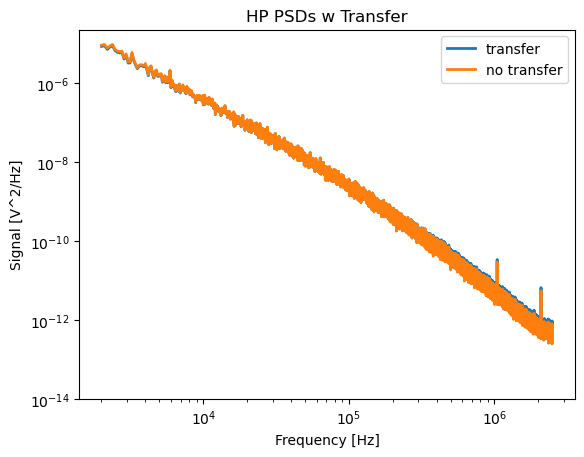

In [48]:
hp_avg_psd_nt = hp_avg_psd
hp_avg_psd = transfer(frequency, hp_avg_psd)

plt.plot(frequency, hp_avg_psd, label="transfer", linewidth=2)
plt.plot(frequency, hp_avg_psd_nt,label="no transfer",linewidth=2)
plt.xscale("log")
plt.yscale("log")
plt.ylim(bottom=1e-14)
plt.legend()
plt.title("HP PSDs w Transfer")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")

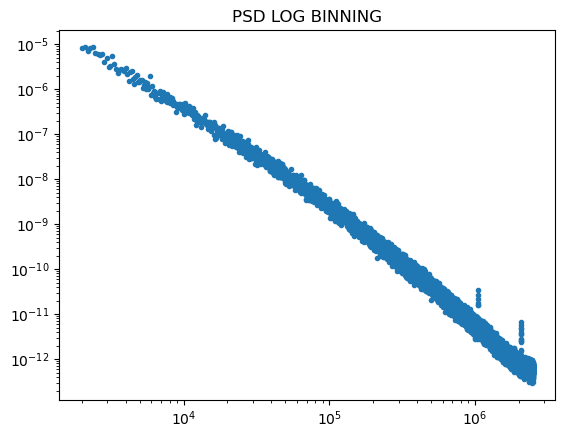

In [49]:
from fitting import log_bin_array, PSD_fitting, PSD_fitting_func

# frequency, hp_avg_psd = log_bin_array(frequency, hp_avg_psd, 1e-1, 1e7, 100)

plt.plot(frequency, hp_avg_psd, ".")
plt.title("PSD LOG BINNING")
plt.xscale("log")
plt.yscale("log")
plt.show()

Function evaluation: x=[5.0e-01 1.0e-10 1.0e-06 5.4e+07], Likelihood=-666588.7512364187
Function evaluation: x=[1.94073176e-01 1.00000000e-10 1.00000000e-06 5.40000000e+07], Likelihood=-658728.5079378288
Function evaluation: x=[3.10926824e-01 1.00000000e-10 1.00000000e-06 5.40000000e+07], Likelihood=-661876.21202093
Function evaluation: x=[3.83146351e-01 1.00000000e-10 1.00000000e-06 5.40000000e+07], Likelihood=-663741.0401368474
Function evaluation: x=[4.27780473e-01 1.00000000e-10 1.00000000e-06 5.40000000e+07], Likelihood=-664854.9539297579
Function evaluation: x=[4.55365878e-01 1.00000000e-10 1.00000000e-06 5.40000000e+07], Likelihood=-665527.4620019685
Function evaluation: x=[4.72414595e-01 1.00000000e-10 1.00000000e-06 5.40000000e+07], Likelihood=-665936.8058256442
Function evaluation: x=[4.82951282e-01 1.00000000e-10 1.00000000e-06 5.40000000e+07], Likelihood=-666187.3526303617
Function evaluation: x=[4.89463313e-01 1.00000000e-10 1.00000000e-06 5.40000000e+07], Likelihood=-6663

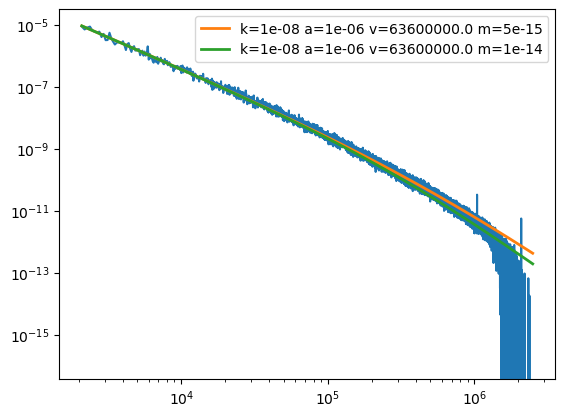

In [50]:
from fitting import log_bin_array, PSD_fitting, PSD_fitting_func

a_guess = 1e-6
v_guess = 5.4e7
m_guess = 5e-15
k_guess = 1e-10

a_plot = [1e-6]
v_plot = [6.36e7]
m_plot = [5e-15, 10e-15]
k_plot = [1e-8]

# bounds = [(a_guess, a_guess), (m_guess, m_guess), (k_guess, k_guess), (v_guess, v_guess)]

optimal_parameters = PSD_fitting(frequency[1:], hp_avg_psd[1:], a_guess, m_guess, k_guess, v_guess)

optimal_parameters.x[0] = optimal_parameters.x[0]*1e-14
PSD_fit = PSD_fitting_func(frequency[1:] * 2 * np.pi, optimal_parameters.x[0], optimal_parameters.x[1], optimal_parameters.x[2], optimal_parameters.x[3])


print("Parameters = ", optimal_parameters.x)
# plt.text(0.1, 0.1, f"Optimal Values:\nMass = {optimal_parameters.x[0]}\nK = {optimal_parameters.x[1]}\nA = {optimal_parameters.x[2]}\nV = {optimal_parameters.x[3]}",
#          fontsize=8, ha='left', va='bottom', transform=plt.gca().transAxes)
#
# plt.text(0.1, 0.3, f"True Values:\nMass = {conf_hp.mass_total}\nK = {.1}\nA = {conf_hp.a}\nV = {1}",
#          fontsize=8, ha='left', va='bottom', transform=plt.gca().transAxes)

plt.plot(frequency[1:], hp_avg_psd[1:])

# plt.axhline(2*const.k_b*conf.temp*config.gamma/k_guess**2)

# plt.plot(frequency[1:], PSD_fit, label=f"fit k={optimal_parameters.x[1]:.{3}g} a={optimal_parameters.x[2]:.{3}g} v={optimal_parameters.x[3]:.{3}g} m={optimal_parameters.x[0]:.{3}g}")
for a in a_plot:
    for k in k_plot:
        for v in v_plot:
            for m in m_plot:
                PSD_true = PSD_fitting_func(frequency[1:] * 2 * np.pi, m, k, a, v)
                plt.plot(frequency[1:], PSD_true, linewidth=2, label=f"k={k} a={a} v={v} m={m}")

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()


Processing data for 
Reading  C:\Users\mcthu\Downloads\2 micron data\strong_trap_bright 0
data_col  X
Reading  C:\Users\mcthu\Downloads\2 micron data\strong_trap_bright 1
data_col  X
Reading  C:\Users\mcthu\Downloads\2 micron data\strong_trap_bright 2
data_col  X
Reading  C:\Users\mcthu\Downloads\2 micron data\strong_trap_bright 3
data_col  X
Reading  C:\Users\mcthu\Downloads\2 micron data\strong_trap_bright 4
data_col  X
MASS TOTAL IS 1.1309733552923254e-14
d: 2e-06
a: 1e-06
eta: 0.001
rho_silica: 2200
rho_f: 1000
sampling_rate: 200000000.0
track_len: 2097152
stop: None
start: None
mass: 9.215338450530058e-15
mass_total: 1.1309733552923254e-14
gamma: 1.884955592153876e-08
t_c: 5.999999999999999e-07
v_c: 0.0005980662083205732
x_c: 3.5883972499234386e-10
timestep: 5e-09


C:\Users\mcthu\PycharmProjects\Brownian_Data_Analysis\fitting.py:28: RuntimeWarning: divide by zero encountered in divide
  return V**2 * numerator / denominator


ValueError: x and y must have same first dimension, but have shapes (209716,) and (209714,)

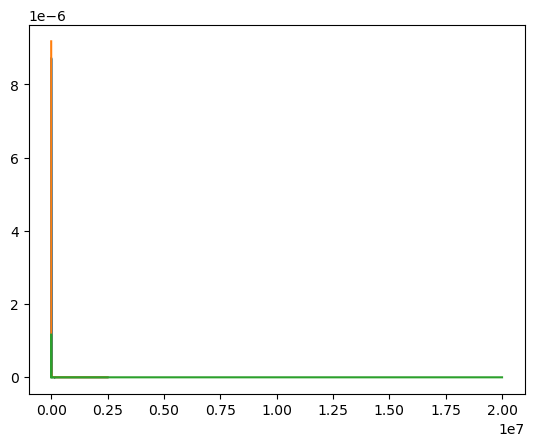

In [51]:
HPB_filename = r"C:\Users\mcthu\Downloads\2 micron data\strong_trap_bright"
hpb_offset = 1887160371
num_files = 5
traces_per_file = 3
traces_HPB = check_and_load_or_process("", hpb_offset, HPB_filename, "X", num_files, traces_per_file)

time_hpb = np.arange(0, len(traces_HPB[0]['series']))
conf_hpb = Config(**traces_HPB[0]['args'])
conf_hpb.print()
time_hpb = time_hpb * (1/conf_hpb.sampling_rate)

bin = 5
all_hpb_series = []

for trace in traces_HPB:
    series = bin_data(trace['series'], bin)
    all_hpb_series.append(series)

all_hpb_psd = []
frequency_b = 0

for series in all_hpb_series:
    frequency_b, psd = scipy.signal.periodogram(series, fs=conf_hpb.sampling_rate/bin, scaling="density")
    all_hpb_psd.append(psd)

hpb_avg_psd = np.mean(all_hpb_psd, axis=0)

plt.plot(frequency[1:], hp_avg_psd[1:])
plt.plot(frequency[1:], PSD_true, label="true")
plt.plot(frequency_b, hpb_avg_psd, label="Bright Noise")
plt.plot(frequency_b, PSD_fitting_func(frequency_b * 2 * np.pi, m_guess, 0, a_guess, 5e7)[2:]+hpb_avg_psd[2:], label="true+bright")
plt.legend()
plt.ylim(bottom=1e-14)
plt.title("Bright Noise")
plt.xscale('log')
plt.yscale('log')
